# Sentinel 2 interactive pixel drill and spectral explorer

**Background** Sentinel 2 data is currently under development and not available for public use as yet. This notebook is working off an internal development instance of DEA, and will form part of the DEA documentation once Sentinel 2 is moved to production.

**What does this notebook do?** This notebook uses a series of widgets to allow the user to explore a region both in space, time and spectra. Data are loaded for a region for the Sentinel2 sensor, and then filtered to remove cloudy scenes. The user then selects a location from a plot to return a time series of one of the spectral bands for that location through all time. The user then selects a point on the time series to pull back the satellite image for that time. The user can then select one or more pixels from that scene to compare their spectra. 

**Date**: May 2018.

**Author**: Claire Krause

In [1]:
%pylab notebook

from datacube import Datacube

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets
import pandas as pd

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting

# The path to the Sentinel 2 development DEA instance configuration file
s2dc = Datacube(config=(os.path.expanduser('~/Sentinel2_datacube.conf')))

Populating the interactive namespace from numpy and matplotlib


## Define the functions that do all of the work 

These functions perform all of the work in this notebook. We have put all of the processing within this function so that all the calculations are done following a 'click' and therefore do not need to be in separate cells. This makes the notebook smoother and minimises the cells that need to be manually run by the user once a location has been selected.

In [2]:
def onclick_pixel(event):
    '''
    This widget allows the user to select a location on an image, and 
    find the closest pixel value to the chosen location.
    '''
    global pixelx, pixely
    pixelx, pixely = int(event.xdata), int(event.ydata)
    w1.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
    plt.plot(pixelx, pixely, 'ro', markersize=5)

def onclick_timeseries(event):
    '''
    This widget allows the user to select a time point from a plotted time series. 
    It then translates the chosen point back into the approriate datetime object so
    that it can be used to find the location of this time point within the extracted
    datasets. The index location of this time step is also returned. 
    
    '''
    global time_slice, TimeIndex
    timeOfInterest = event.xdata
    # Convert clicked int to datetime format
    time_slice = matplotlib.dates.num2date(timeOfInterest).date()
    # Convert clicked value to str
    time_slice = str(time_slice)
    # Convert clicked value to correct datetime format
    time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
    # Find the time index of the chosen time slice
    TimeIndex = Resolution60mFiltered.indexes['time'].get_loc(time_slice, method='nearest')
    w2.value = 'time of interest : {}'.format(time_slice)

def onclick_spectra(event):
    '''
    This widget function uses the selected to location to plot the spectra of 
    the pixel closest to the chosen location. It uses the clicked location to
    find the closese pixel, then collate the band values for that pixel into a list, ready
    to be plotted in the subsequent cell.
    '''
    global pixelxx, pixelyy, spectra, spectramin, spectramax, spectramean, clickCount
    pixelxx, pixelyy = int(event.xdata), int(event.ydata)
    w3.value = 'pixelxx : {}, pixelyy : {}'.format(pixelxx, pixelyy)
    plt.plot(pixelxx, pixelyy, 'ro', markersize=5)
    clickCount +=1

    # Find the pixel closest to the chosen pixel at each resolution
    Pixel10m = Resolution10mFiltered.sel(y=pixelyy, x=pixelxx, method='nearest')
    Pixel20m = Resolution20mFiltered.sel(y=pixelyy, x=pixelxx, method='nearest')
    Pixel60m = Resolution60mFiltered.sel(y=pixelyy, x=pixelxx, method='nearest')

    # Grab the pixel spectral values for each band
    spectralist = [Pixel60m.aerosol.isel(time=TimeIndex).values,
               Pixel10m.blue.isel(time=TimeIndex).values,
               Pixel10m.green.isel(time=TimeIndex).values,
               Pixel10m.red.isel(time=TimeIndex).values,
               Pixel20m.rededge1.isel(time=TimeIndex).values,
               Pixel20m.rededge2.isel(time=TimeIndex).values,
               Pixel20m.rededge3.isel(time=TimeIndex).values,
               Pixel10m.nir1.isel(time=TimeIndex).values,
               Pixel20m.nir2.isel(time=TimeIndex).values,
               Pixel20m.swir1.isel(time=TimeIndex).values,
               Pixel20m.swir2.isel(time=TimeIndex).values,
               ]
    spectra.append(spectralist)

## Set up the extraction queries and load the corresponding data

### Grab the 10m resolution bands

In [3]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        }

Resolution10m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['blue', 'green', 'red', 'nir1', 'pixel_quality'], **query)

### Grab the 20m resolution bands

In [4]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        }

Resolution20m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['rededge1', 'rededge2', 'rededge3', 'nir2', 'swir1', 'swir2'], **query)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


### Grab the 60m resolution aerosol band

In [5]:
query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-60, 60),
        }

Resolution60m = s2dc.load(product='s2a_ard_granule', group_by='solar_day', 
                          measurements = ['aerosol'], **query)

## Filter the data to only keep scenes with a desired percentage of clear pixels

This threshold is set in the `acceptable_missing_data` variable as a fraction, where 0 = 100% clear pixels. 

In [6]:
acceptable_missing_data = 0.5

In [7]:
# Create boolean mask where the pixel quality flag == 1 (aka 'clear pixel')
PQmask = Resolution10m.where(Resolution10m.pixel_quality == 1)

In [8]:
# We will make copies of the original data so that we don't have to re-extract the data if 
# we want to change the threshold
Resolution10mFiltered = Resolution10m.copy(deep = True)
Resolution20mFiltered = Resolution20m.copy(deep = True)
Resolution60mFiltered = Resolution60m.copy(deep = True)

# Find the total number of pixels in our scene * the acceptable_missing_data to find our threshold
threshold = Resolution10m.x.count() * Resolution10m.y.count() * acceptable_missing_data

# Apply the filter threshold to the 10m data
Resolution10mFiltered = Resolution10m.where(PQmask.green.isnull().sum(axis=(1, 2)) 
                                            <= int(threshold)).dropna(dim='time')

# Use the times in the filtered 10m data to filter the remaining layers
Resolution20mFiltered = Resolution20m.where(Resolution10mFiltered.time).dropna(dim='time')
Resolution60mFiltered = Resolution60m.where(Resolution10mFiltered.time).dropna(dim='time')

## Plot the extracted region, and select a pixel for interrogation

Click on the pixel you would like to interrogate


<IPython.core.display.Javascript object>


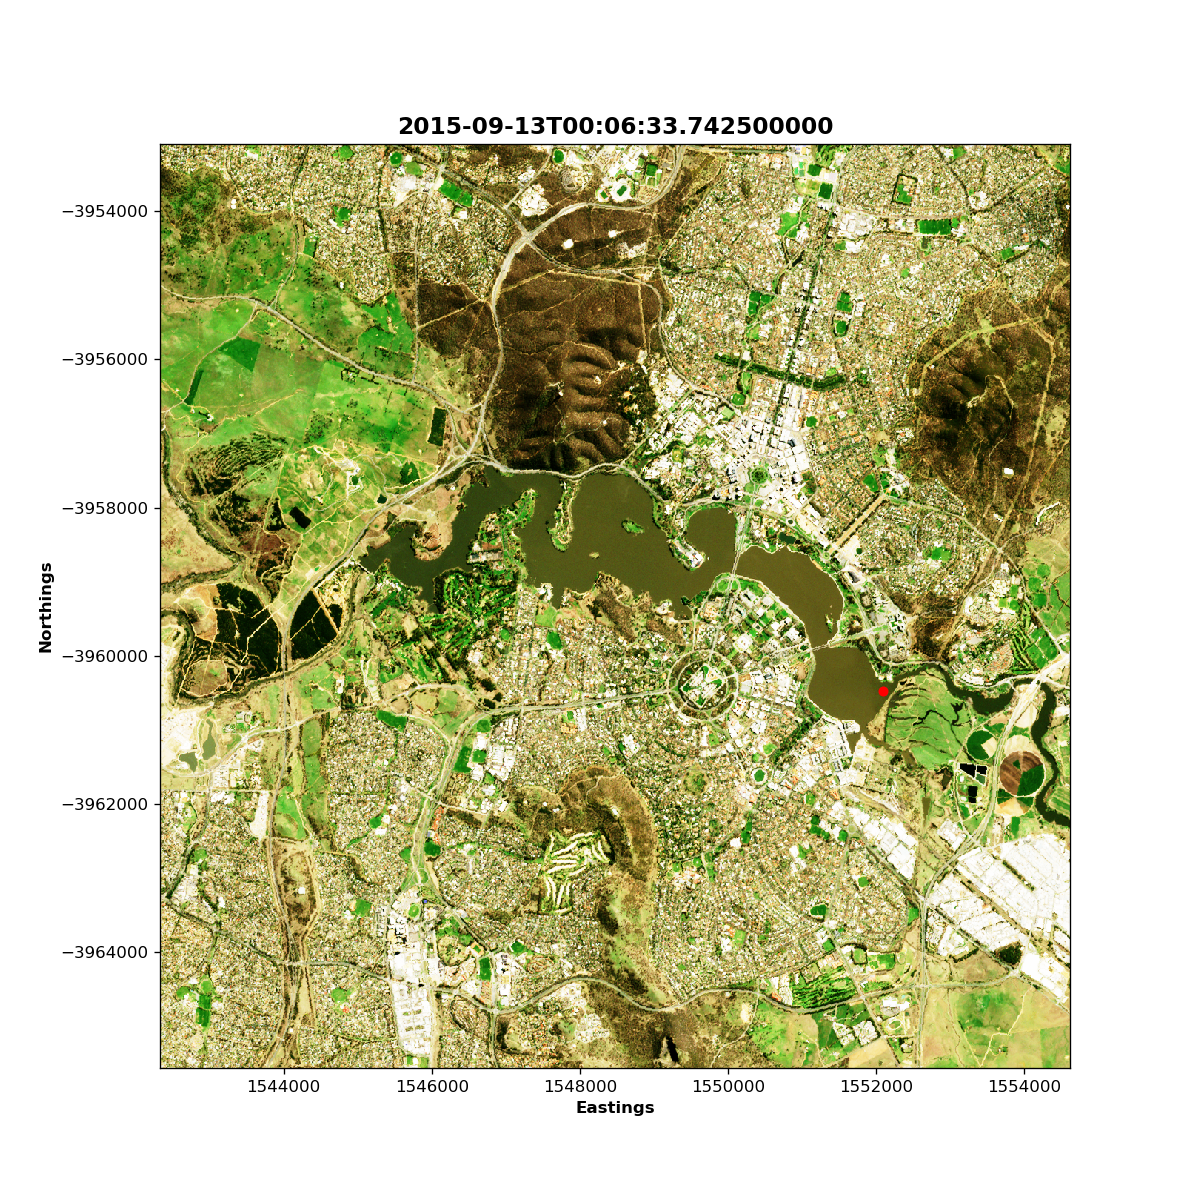

HTML(value='Click on the pixel you would like to interrogate')

In [9]:
print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

DEAPlotting.three_band_image(Resolution10mFiltered, bands = ['red', 'green', 'blue'], 
                             time = 0, contrast_enhance=True)

fig = plt.gcf()
w1 = widgets.HTML("Click on the pixel you would like to interrogate")

cid = fig.canvas.mpl_connect('button_press_event', onclick_pixel)
display(w1)

## Select a time point to see the accompanying satellite image

<IPython.core.display.Javascript object>


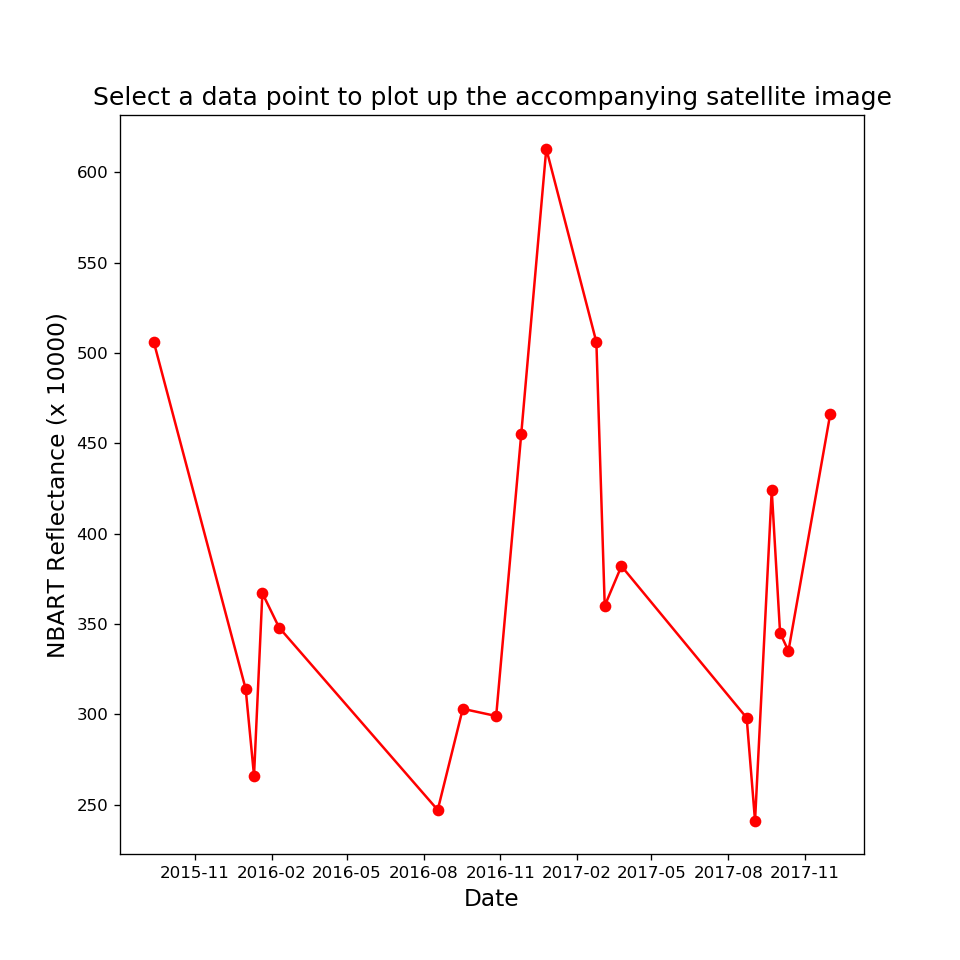

HTML(value='Click on the time you would like to display')

In [10]:
fig = plt.figure(figsize=[8, 8])

plt.plot(Resolution10mFiltered.time, Resolution10mFiltered.green.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=14)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=14)
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=15)

w2 = widgets.HTML("Click on the time you would like to display")

cid = fig.canvas.mpl_connect('button_press_event', onclick_timeseries)
display(w2)

## Click on a pixel to view its spectra

Click on the pixel you would like to interrogate


<IPython.core.display.Javascript object>


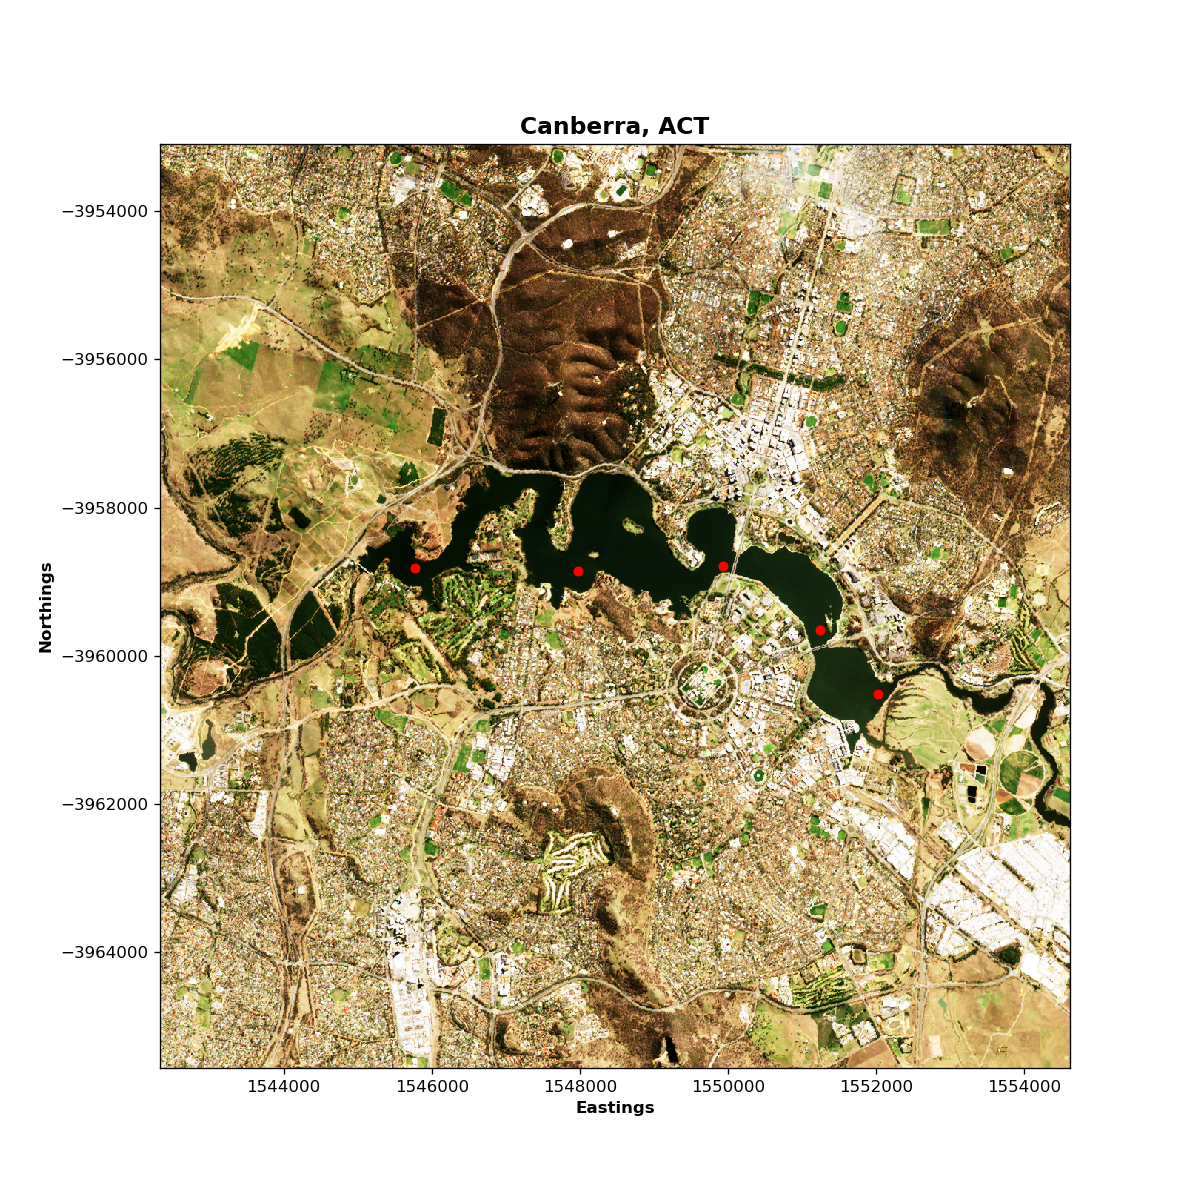

HTML(value='Click on the pixel you would like to interrogate')

In [12]:
print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

DEAPlotting.three_band_image(Resolution10m.sel(time=time_slice, method='nearest'), bands=['red', 'green', 'blue'],
                             title='Canberra, ACT', contrast_enhance=True);

clickCount = 0
spectra = []
fig = plt.gcf()
w3 = widgets.HTML("Click on the pixel you would like to interrogate")

cid = fig.canvas.mpl_connect('button_press_event', onclick_spectra)
display(w3)

## Now plot up the full spectra for that pixel

<IPython.core.display.Javascript object>


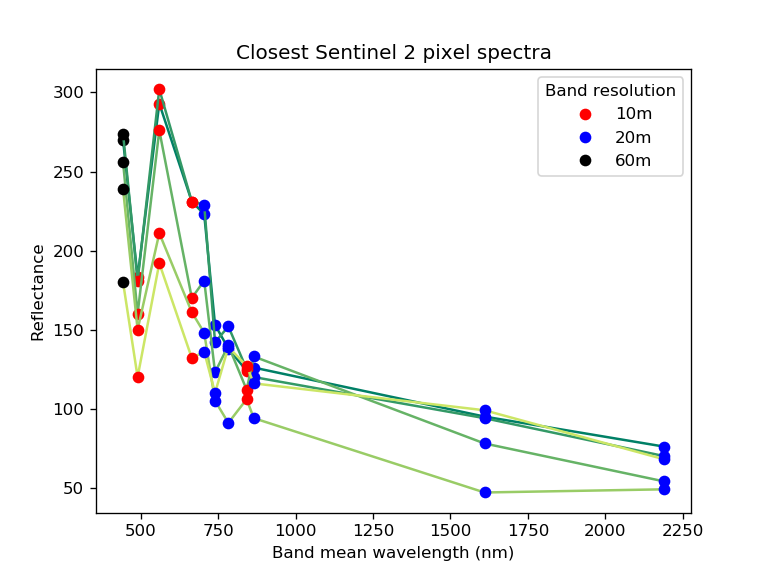

In [13]:
wavelengths = [443, 490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]
wavelengthlabels = ['aerosol', 'blue', 'green', 'red', 'rededge1', 'rededge2',
                    'rededge3', 'nir1', 'nir2', 'swir1', 'swir2']

fig = plt.figure()

cmap = cmap = matplotlib.cm.get_cmap('summer')


for ii in range(clickCount):
    plt.plot(wavelengths, spectra[ii], color = cmap(ii/clickCount), label='_nolegend_')
    plt.plot((list(wavelengths[i] for i in [1, 2, 3, 7])),
             (list(spectra[ii][i] for i in [1, 2, 3, 7])), 'ro')
    plt.plot((list(wavelengths[i] for i in [4, 5, 6, 8, 9, 10])),
             (list(spectra[ii][i] for i in [4, 5, 6, 8, 9, 10])), 'bo')
    plt.plot((list(wavelengths[i] for i in [0])),
             (list(spectra[ii][i] for i in [0])), 'ko')

    plt.xlabel('Band mean wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.legend(['10m', '20m', '60m'], title='Band resolution')
    plt.title('Closest Sentinel 2 pixel spectra')